# Load Data and Packages

In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
# from plotnine import *

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
factory_energy = pd.read_csv('data/energy_consumption.csv')
factory_prod = pd.read_csv('data/production.csv')
factory_temp = pd.read_csv('data/temperature.csv')

In [3]:
# data cleaning for energy (in intervals of minutes)
factory_energy['at'] = pd.to_datetime(factory_energy['at'])
factory_energy = factory_energy.sort_values(by=['at'], ascending=True).reset_index(drop=True)

# data cleaning for production (in seconds)
factory_prod['Confirmation'] = factory_prod['Confirmation'].astype(str)
factory_prod['Ordre'] = factory_prod['Ordre'].astype(str)
factory_prod['Poste de travail'] = factory_prod['Poste de travail'].astype(str)
factory_prod['Centre de coûts'] = factory_prod['Centre de coûts'].astype(str)
factory_prod['sku'] = factory_prod['sku'].astype(str)
factory_prod['at'] = pd.to_datetime(factory_prod['at'])
factory_prod = factory_prod.sort_values(by=['at'], ascending=True).reset_index(drop=True)

# data cleaning for temperature (in intervals of hours)
factory_temp['at'] = pd.to_datetime(factory_temp['at'])
factory_temp = factory_temp.sort_values(by=['at'], ascending=True).reset_index(drop=True)

# Data Preparation

In [4]:
# calculate daily energy: sum(power(in kW) * time_duration(in hours)) per day = kWh per day
factory_energy['at_date'] = factory_energy['at'].dt.date

# create lagged variable to find time duration between current reported power and previous reported power
factory_energy['at_lag'] = factory_energy.groupby(['at_date'])['at'].shift(1)
factory_energy['at_duration'] = list( map(lambda t: (t.total_seconds()) / (60*60), factory_energy['at'] - factory_energy['at_lag']) )
# calculate incremental energy added
factory_energy['papp_lag'] = factory_energy.groupby(['at_date'])['papp'].shift(1)
factory_energy['ind_energy'] = (factory_energy['papp'] + factory_energy['papp_lag']) / 2 * factory_energy['at_duration']
factory_energy['cumul_daily_energy'] = factory_energy.groupby(['at_date'])['ind_energy'].cumsum()
# only keep variables that are important
factory_energy = factory_energy.dropna()[['at', 'papp', 'at_duration', 'ind_energy', 'cumul_daily_energy']]

In [5]:
# merge energy and temperature based on time (i.e. convert time in minutes to closest time in hours)
factory_energy['at_hr'] = list( map(lambda t: t.replace(microsecond=0, second=0, minute=0, hour=t.hour) + timedelta(hours=t.minute//30), factory_energy['at']) )
data = factory_energy.merge(factory_temp, how='inner', left_on='at_hr', right_on='at', suffixes=('_energy', '_temp'))

# merge energy/temperature and production based on time (i.e. convert time in minutes to closest time in minutes)
factory_prod['at_min'] = list( map(lambda t: t.replace(microsecond=0, second=0, minute=t.minute, hour=t.hour) + timedelta(minutes=t.second//30), factory_prod['at']) )
# factory_prod['at_min'] = list( map(lambda t: t.replace(microsecond=0, second=0, minute=0, hour=t.hour) + timedelta(hours=t.minute//30), factory_prod['at']) )
data = factory_prod.merge(data, how='left', left_on='at_min', right_on='at_energy')

# only keep variables that are important
final_data = data[['at', 'at_energy', 'at_temp', 'at_duration', 'Confirmation', 'Ordre', 'Poste de travail', 'Centre de coûts', 'group', 'sku', 'units', 'weight_kg', 'scrap', 'papp', 'cumul_daily_energy', 'T']]
final_data = final_data.dropna()



# check final dataset for any errors
# size of the dataset
print( final_data.shape, '\n' )
# column names and data types
print( final_data.dtypes, '\n' )
# first 5 observations
final_data.head(5)

(8322, 16) 

at                    datetime64[ns, UTC]
at_energy             datetime64[ns, UTC]
at_temp               datetime64[ns, UTC]
at_duration                       float64
Confirmation                       object
Ordre                              object
Poste de travail                   object
Centre de coûts                    object
group                              object
sku                                object
units                               int64
weight_kg                         float64
scrap                               int64
papp                              float64
cumul_daily_energy                float64
T                                 float64
dtype: object 



,at,at_energy,at_temp,at_duration,Confirmation,Ordre,Poste de travail,Centre de coûts,group,sku,units,weight_kg,scrap,papp,cumul_daily_energy,T
273,2024-02-13 11:19:26+00:00,2024-02-13 11:19:00+00:00,2024-02-13 11:00:00+00:00,0.016667,47047917,73973655,40204,208026,4G200150,1208324,732,3.418,0,936.461538,353.399620,10.6
274,2024-02-13 11:26:20+00:00,2024-02-13 11:26:00+00:00,2024-02-13 11:00:00+00:00,0.016667,47247246,74001877,40426,208007,4G130400,1486855,0,0.000,0,959.185185,462.273368,10.6
275,2024-02-13 11:48:16+00:00,2024-02-13 11:48:00+00:00,2024-02-13 12:00:00+00:00,0.016667,47351753,73996160,40834,208009,4G200140,1093064,378000,378.000,0,907.846154,805.334527,11.8
276,2024-02-13 12:12:48+00:00,2024-02-13 12:13:00+00:00,2024-02-13 12:00:00+00:00,0.016667,47209939,73996881,40904,208009,4G200100,1779728,1168000,1168.000,0,926.538462,1175.980799,11.8
277,2024-02-13 12:19:30+00:00,2024-02-13 12:20:00+00:00,2024-02-13 12:00:00+00:00,0.016667,47047917,73973655,40204,208026,4G200150,1208324,1574,7.351,0,931.153846,1282.453710,11.8


In [6]:
# average time between observations in the final dataset
final_data_temp = final_data.copy(deep=True)
final_data_temp['at_date'] = final_data_temp['at'].dt.date

# create lagged variable to find time duration
final_data_temp['at_lag'] = final_data_temp.groupby(['at_date'])['at'].shift(1)
final_data_temp['at_duration'] = list( map(lambda t: (t.total_seconds()) / (60*60), final_data_temp['at'] - final_data_temp['at_lag']) )
# print average time duration
print(
    ' Median Time Duration:\t', final_data_temp['at_duration'].median(), '\n',
    'Average Time Duration:\t', final_data_temp['at_duration'].mean(), '\n',
    'Time Duration Error:\t', final_data_temp['at_duration'].std() / math.sqrt(len(final_data_temp))
)

 Median Time Duration:	 0.013333333333333334 
 Average Time Duration:	 0.0876132445088489 
 Time Duration Error:	 0.002421299059650415


# Data Visualizations

## Energy

Text(0.5, 1.0, 'Power (kW) over time')

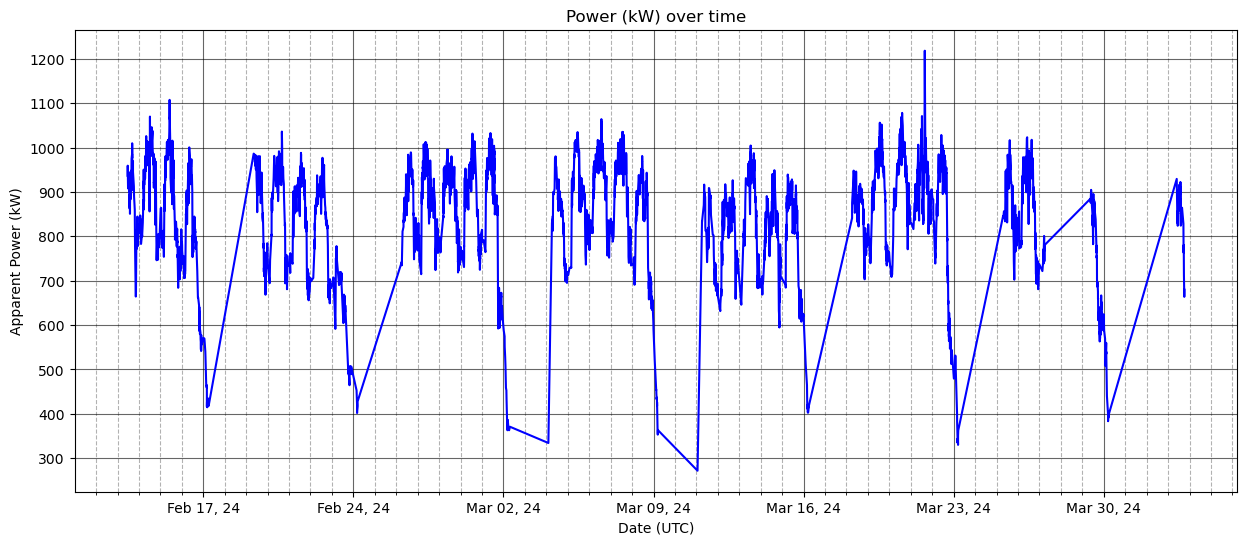

In [7]:
# power
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(final_data['at'], final_data['papp'], color='blue')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=100))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.xlabel('Date (UTC)')
plt.ylabel('Apparent Power (kW)')
plt.title('Power (kW) over time')

Text(0.5, 1.0, 'Cumulative daily energy (kWh per day) over time')

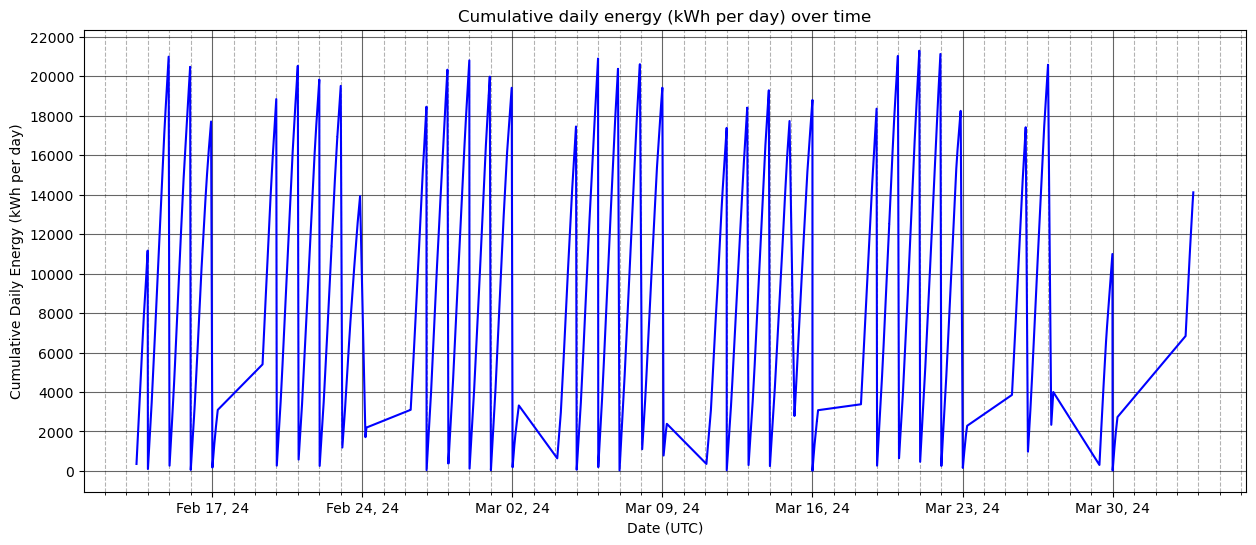

In [8]:
# cumulative energy added by day
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(final_data['at'], final_data['cumul_daily_energy'], color='blue')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=2000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.xlabel('Date (UTC)')
plt.ylabel('Cumulative Daily Energy (kWh per day)')
plt.title('Cumulative daily energy (kWh per day) over time')

## Temperature

Text(0.5, 1.0, 'Temperature (Celsius) over time')

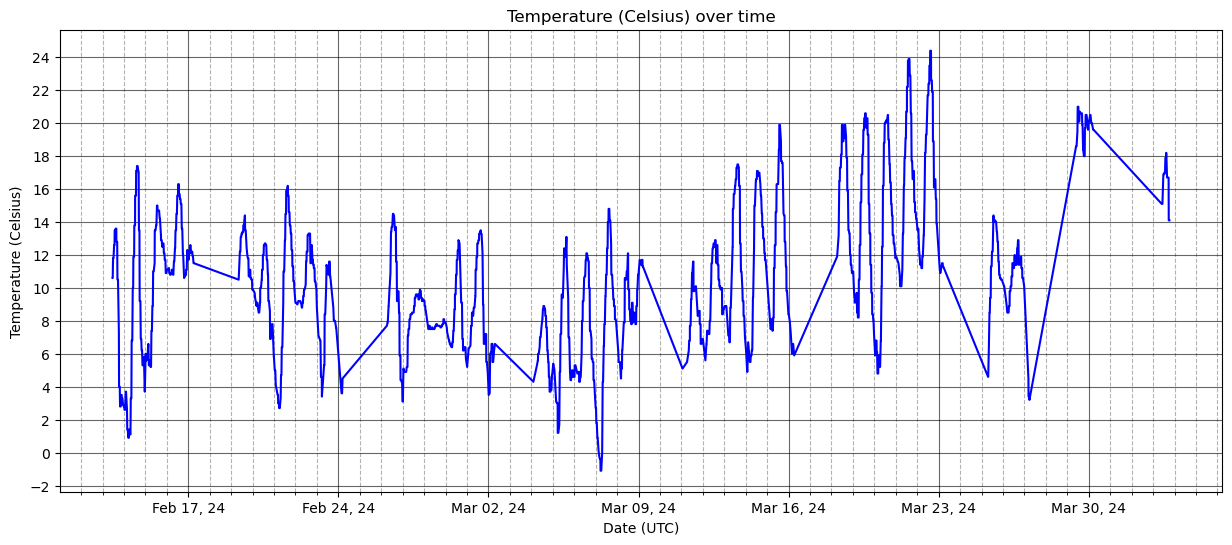

In [9]:
# temperature
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(final_data['at'], final_data['T'], color='blue')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=2))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.xlabel('Date (UTC)')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature (Celsius) over time')

## Production

Text(0.5, 1.0, 'Number of units produced over time')

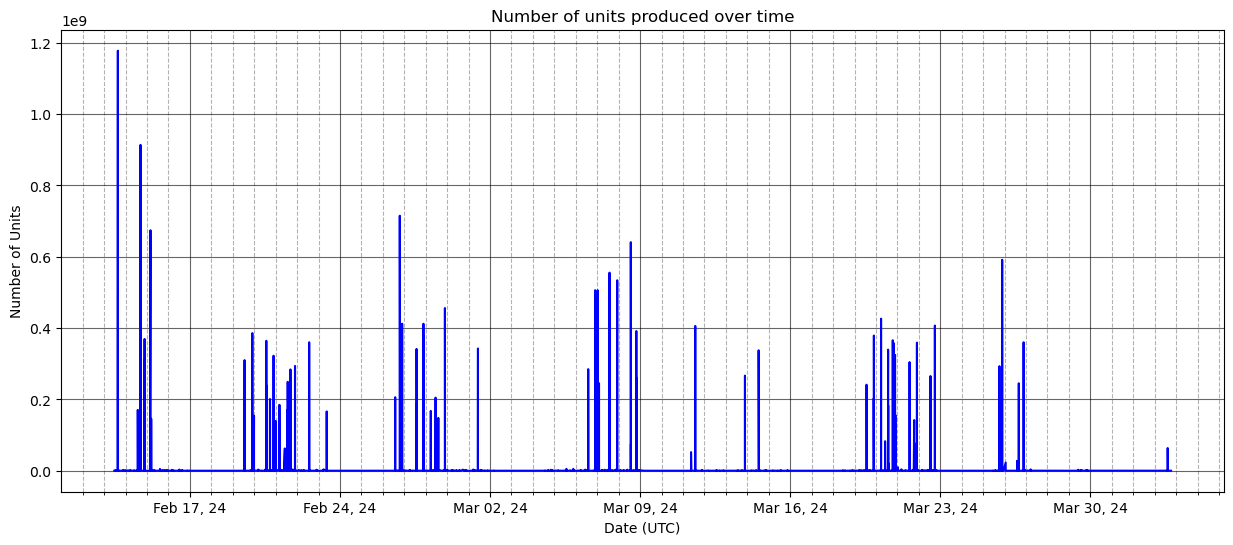

In [10]:
# units
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(final_data['at'], final_data['units'], color='blue')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.2e9))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.xlabel('Date (UTC)')
plt.ylabel('Number of Units')
plt.title('Number of units produced over time')

Text(0.5, 1.0, 'Amount of weight produced (kg) over time')

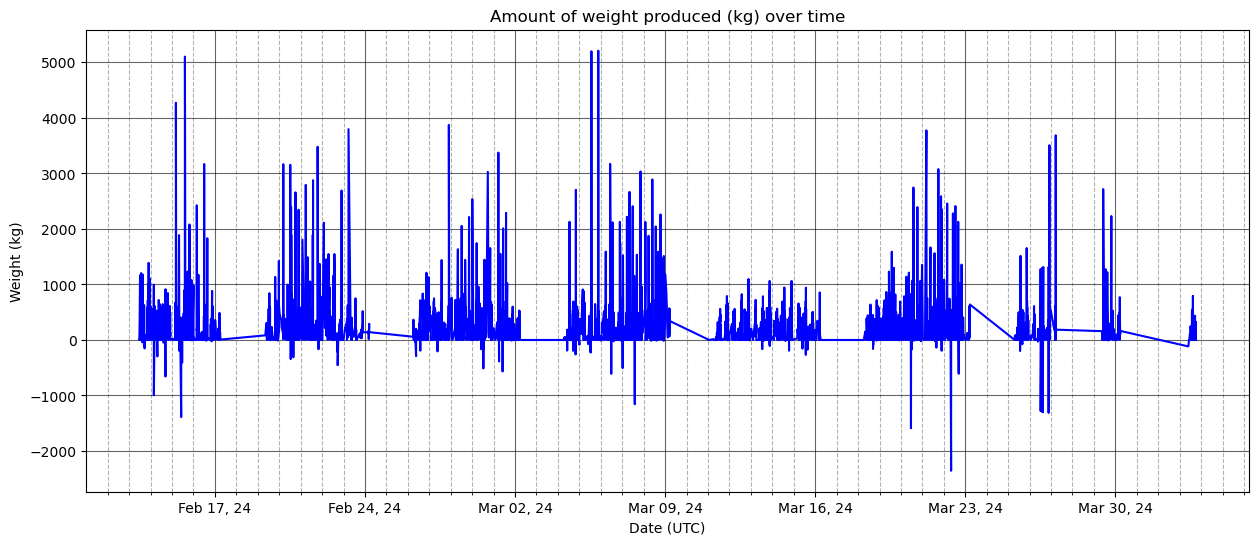

In [11]:
# weight_kg
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(final_data['at'], final_data['weight_kg'], color='blue')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=1000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.xlabel('Date (UTC)')
plt.ylabel('Weight (kg)')
plt.title('Amount of weight produced (kg) over time')

Text(0.5, 1.0, 'Number of scraps produced over time')

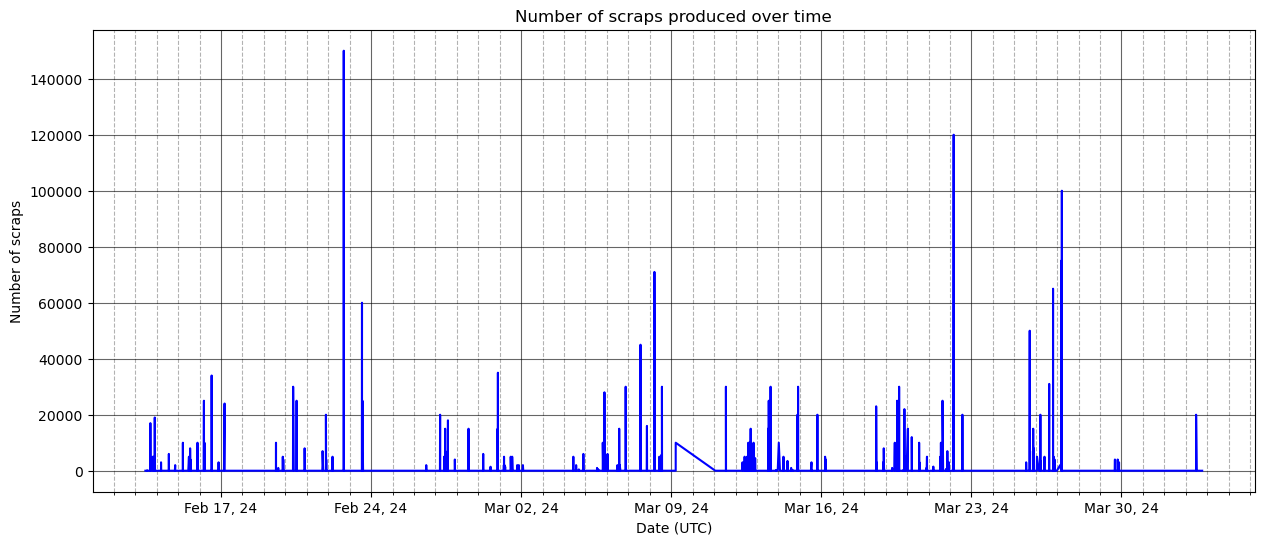

In [12]:
# scrap
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(final_data['at'], final_data['scrap'], color='blue')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=20000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.xlabel('Date (UTC)')
plt.ylabel('Number of scraps')
plt.title('Number of scraps produced over time')

# Energy

In [13]:
var_to_predict = 'cumul_daily_energy'

data_model = final_data.drop(['Confirmation', 'Ordre', 'at', 'at_energy', 'at_temp'], axis=1)
data_model_num = data_model.select_dtypes(include=['int64', 'float64']).drop([var_to_predict], axis=1)
data_model_cat = data_model.select_dtypes(exclude=['int64', 'float64'])
n_train = math.floor(0.8 * len(data_model))

# split data into initial training / testing data with a 80% to 20% split
trainX_num = data_model_num[0:n_train]
trainY = data_model[[var_to_predict]][0:n_train]

testX_num = data_model_num[n_train:]
testY = data_model[[var_to_predict]][n_train:]

# apply normalization and one-hot encoding
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

trainX_num = scalerX.fit_transform(trainX_num)
trainY = scalerY.fit_transform(trainY)

testX_num = scalerX.transform(testX_num)
testY = scalerY.transform(testY)

data_unit_cat = pd.get_dummies(data_model_cat)

# get final training and testing data
data_scaled = pd.DataFrame(
    np.concatenate((np.concatenate((trainX_num, testX_num), axis=0), data_unit_cat), axis=1),
    columns=list(data_model_num.columns) + list(data_unit_cat.columns)
)

trainX = data_scaled[0:n_train]
testX = data_scaled[n_train:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(6657, 529) (6657, 1)
(1665, 529) (1665, 1)


In [14]:
# combine predictors and response variable
train_dataset = np.concatenate((trainX, trainY), axis=1)
test_dataset = np.concatenate((testX, testY), axis=1)

print(train_dataset.shape, test_dataset.shape)

(6657, 530) (1665, 530)


In [15]:
# Function to process the data into # look_back days, # predict days slices
def convert_ts(data, look_back, look_forward):
    datX, datY = [], []
    for i in range(len(data)-look_back-look_forward+1):
        a = data[i:(i+look_back), :]
        datX.append(a)
        datY.append(data[i+look_back+look_forward-1, -1])
    return np.array(datX), np.array(datY).reshape(-1, 1)

In [16]:
# convert data into lagged data
look_back = 30
look_forward = 5
trainX_ts, trainY_ts = convert_ts(train_dataset, look_back, look_forward)
testX_ts, testY_ts = convert_ts(test_dataset, look_back, look_forward)

print( trainX_ts.shape, trainY_ts.shape )
print( testX_ts.shape, testY_ts.shape )

(6623, 30, 530) (6623, 1)
(1631, 30, 530) (1631, 1)


In [17]:
# change format of lagged data so linear and tree models can properly use
trainX_ts_2d = trainX_ts.reshape(-1, trainX_ts.shape[1] * trainX_ts.shape[2])
trainY_ts_2d = trainY_ts.reshape(-1, 1)

testX_ts_2d = testX_ts.reshape(-1, testX_ts.shape[1] * testX_ts.shape[2])
testY_ts_2d = testY_ts.reshape(-1, 1)

print( trainX_ts_2d.shape, trainY_ts_2d.shape )
print( testX_ts_2d.shape, testY_ts_2d.shape )

# column names
col_names = [col + ' at lag ' + str(i+1) for i in reversed(range(look_back)) for col in (list(data_scaled.columns) + [var_to_predict])]

(6623, 15900) (6623, 1)
(1631, 15900) (1631, 1)


## Linear

In [18]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import metrics

In [19]:
# fit linear model
model_linear = Ridge(alpha=50)
model_linear.fit(trainX_ts_2d, trainY_ts_2d)

# evaluate model with RMSE
train_preds = scalerY.inverse_transform( model_linear.predict(trainX_ts_2d) )
print('Training Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(trainY_ts_2d), train_preds ) ) )

test_preds = scalerY.inverse_transform( model_linear.predict(testX_ts_2d) )
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(testY_ts_2d) , test_preds ) ) )

Training Error: 1497.5236916906194
Testing Error: 2603.393796291767


In [20]:
model_linear_coefs = pd.DataFrame(
    model_linear.coef_.reshape(-1,1),
    index=col_names,
    columns=['coef']
)
model_linear_coefs.sort_values(by=['coef'], key=abs, ascending=False).head(20)

,coef
cumul_daily_energy at lag 1,0.269692
cumul_daily_energy at lag 2,0.173199
cumul_daily_energy at lag 3,0.114154
cumul_daily_energy at lag 4,0.077517
cumul_daily_energy at lag 5,0.053853
cumul_daily_energy at lag 6,0.039797
sku_1147917 at lag 24,-0.035307
sku_1099285 at lag 8,-0.032936
cumul_daily_energy at lag 7,0.030365
sku_1099285 at lag 7,-0.030135


Text(0.5, 1.0, 'Cumulative daily energy (kWh per day) over time')

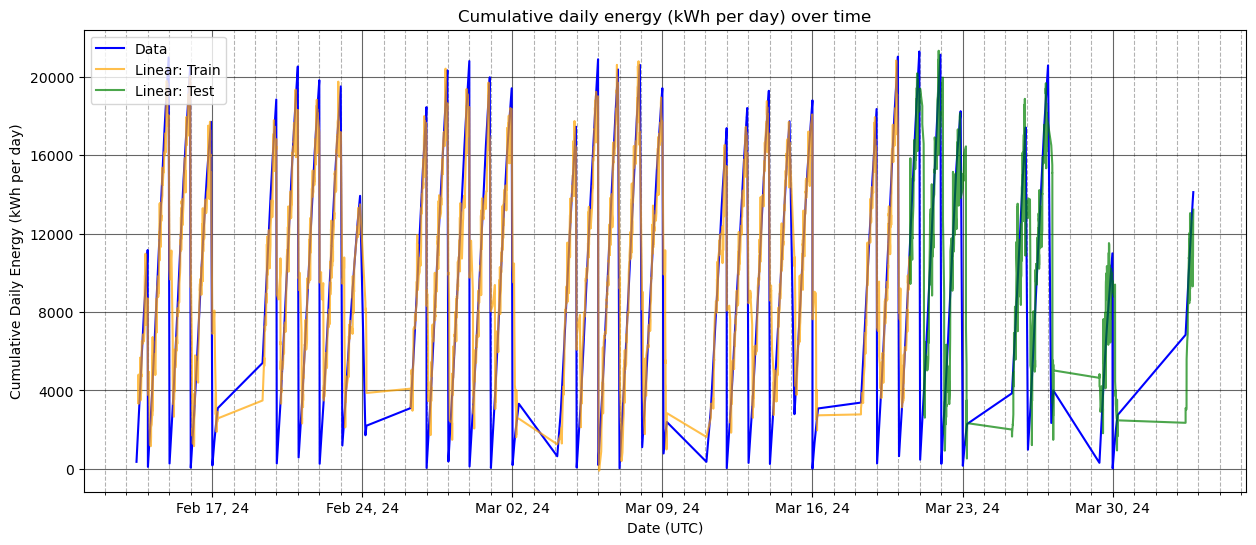

In [21]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
test_predict_plot[(2*(look_back+look_forward-1)+len(train_preds)):(2*(look_back+look_forward-1)+len(train_preds)+len(test_preds)), :] = test_preds.reshape(-1,1)

plt.plot(final_data['at'], final_data[var_to_predict], color='blue', label='Data')
plt.plot(final_data['at'], train_predict_plot, color='orange', alpha=0.7, label='Linear: Train')
plt.plot(final_data['at'], test_predict_plot, color='green', alpha=0.7, label='Linear: Test')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=4000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Cumulative Daily Energy (kWh per day)')
plt.title('Cumulative daily energy (kWh per day) over time')

## Tree

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
# fit decision tree model
model_tree = DecisionTreeRegressor(max_depth=4)
model_tree.fit(trainX_ts_2d, trainY_ts_2d)

# evaluate model with RMSE
train_preds = scalerY.inverse_transform( model_tree.predict(trainX_ts_2d).reshape(-1,1) )
print('Training Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(trainY_ts_2d), train_preds ) ) )

test_preds = scalerY.inverse_transform( model_tree.predict(testX_ts_2d).reshape(-1,1) )
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(testY_ts_2d) , test_preds ) ) )

Training Error: 1992.6428076943391
Testing Error: 1941.8940855051892


In [24]:
model_tree_coefs = pd.DataFrame(
    model_tree.feature_importances_,
    index=col_names,
    columns=['coef']
)
model_tree_coefs.sort_values(by=['coef'], key=abs, ascending=False).head(20)

,coef
cumul_daily_energy at lag 1,0.969282
cumul_daily_energy at lag 8,0.017866
weight_kg at lag 8,0.005806
papp at lag 15,0.003884
T at lag 6,0.002088
sku_970343 at lag 18,0.001073
sku_994501 at lag 11,0.000000
sku_996671 at lag 11,0.000000
sku_999170 at lag 11,0.000000
cumul_daily_energy at lag 11,0.000000


Text(0.5, 1.0, 'Cumulative daily energy (kWh per day) over time')

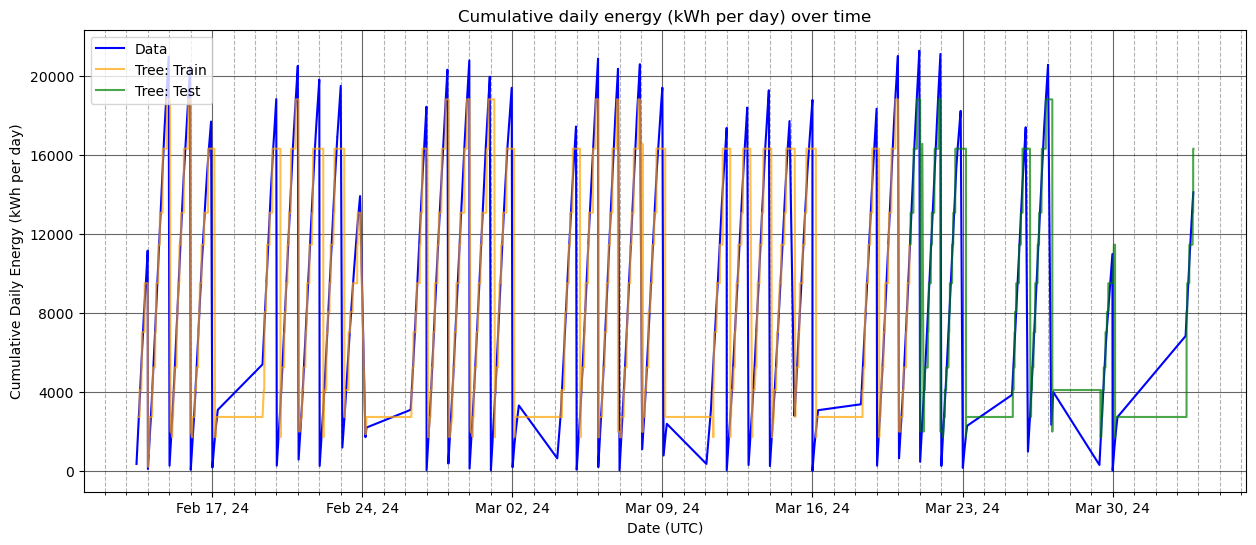

In [25]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
test_predict_plot[(2*(look_back+look_forward-1)+len(train_preds)):(2*(look_back+look_forward-1)+len(train_preds)+len(test_preds)), :] = test_preds.reshape(-1,1)

plt.plot(final_data['at'], final_data[var_to_predict], color='blue', label='Data')
plt.plot(final_data['at'], train_predict_plot, color='orange', alpha=0.7, label='Tree: Train')
plt.plot(final_data['at'], test_predict_plot, color='green', alpha=0.7, label='Tree: Test')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=4000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Cumulative Daily Energy (kWh per day)')
plt.title('Cumulative daily energy (kWh per day) over time')

## Recurrent Neural Net

In [26]:
from keras.api.models import Sequential
from keras.api.layers import Dense, LSTM, Dropout

In [27]:
# define model (50-layer LSTM)
def create_lstm():
    model = Sequential()
    model.add(LSTM(50))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    
    return model

In [28]:
# define model, criterion, and optimizer
model_rnn = create_lstm()
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# train model
model_hist = model_rnn.fit(
    trainX_ts, trainY_ts, epochs=20
)

Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1151
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0373
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0181
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0075
Epoch 9/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065
Epoch 10/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0057
Epoch 11/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055
Epoch 12/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052
Epoch 13/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048
Epoch 14/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042
Epoch 15/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

In [29]:
# evaluate model with RMSE
train_preds = scalerY.inverse_transform(model_rnn.predict(trainX_ts))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(trainY_ts), train_preds ) ) )

test_preds = scalerY.inverse_transform(model_rnn.predict(testX_ts))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(testY_ts) , test_preds ) ) )

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training Error: 608.988403026137
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing Error: 2802.181285630429


Text(0.5, 1.0, 'Cumulative daily energy (kWh per day) over time')

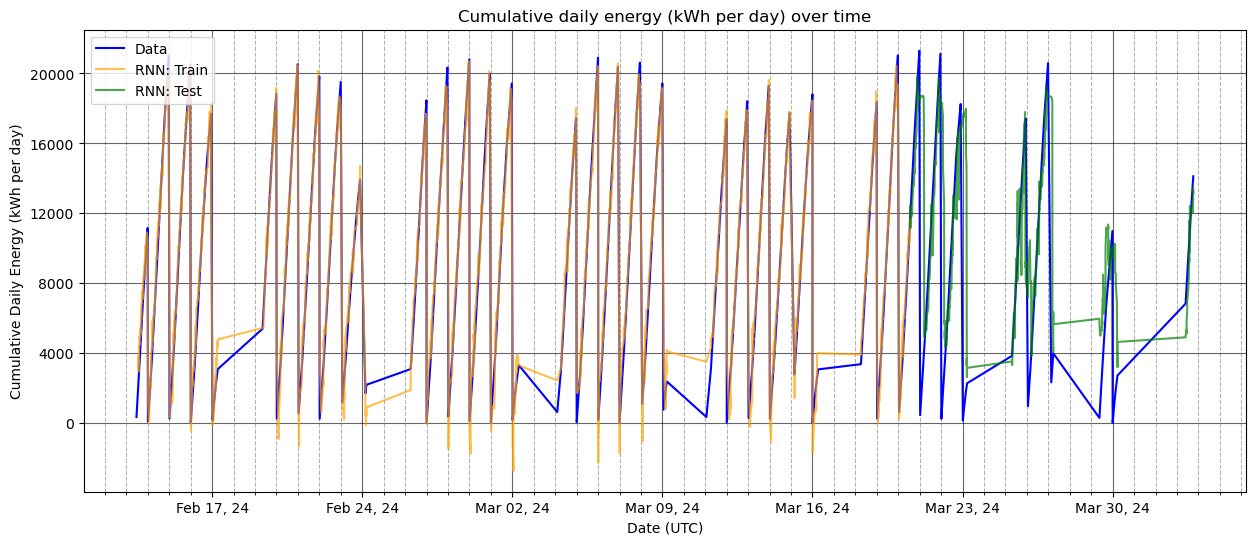

In [30]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
test_predict_plot[(2*(look_back+look_forward-1)+len(train_preds)):(2*(look_back+look_forward-1)+len(train_preds)+len(test_preds)), :] = test_preds.reshape(-1,1)

plt.plot(final_data['at'], final_data[var_to_predict], color='blue', label='Data')
plt.plot(final_data['at'], train_predict_plot, color='orange', alpha=0.7, label='RNN: Train')
plt.plot(final_data['at'], test_predict_plot, color='green', alpha=0.7, label='RNN: Test')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=4000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Cumulative Daily Energy (kWh per day)')
plt.title('Cumulative daily energy (kWh per day) over time')

# Weight

In [31]:
var_to_predict = 'weight_kg'

data_model = final_data.drop(['Confirmation', 'Ordre', 'at', 'at_energy', 'at_temp'], axis=1)
data_model_num = data_model.select_dtypes(include=['int64', 'float64']).drop([var_to_predict], axis=1)
data_model_cat = data_model.select_dtypes(exclude=['int64', 'float64'])
n_train = math.floor(0.8 * len(data_model))

# split data into initial training / testing data with a 80% to 20% split
trainX_num = data_model_num[0:n_train]
trainY = data_model[[var_to_predict]][0:n_train]

testX_num = data_model_num[n_train:]
testY = data_model[[var_to_predict]][n_train:]

# apply normalization and one-hot encoding
scalerX = StandardScaler()
scalerY = StandardScaler()

trainX_num = scalerX.fit_transform(trainX_num)
trainY = scalerY.fit_transform(trainY)

testX_num = scalerX.transform(testX_num)
testY = scalerY.transform(testY)

data_unit_cat = pd.get_dummies(data_model_cat)

# get final training and testing data
data_scaled = pd.DataFrame(
    np.concatenate((np.concatenate((trainX_num, testX_num), axis=0), data_unit_cat), axis=1),
    columns=list(data_model_num.columns) + list(data_unit_cat.columns)
)

trainX = data_scaled[0:n_train]
testX = data_scaled[n_train:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(6657, 529) (6657, 1)
(1665, 529) (1665, 1)


In [32]:
# combine predictors and response variable
train_dataset = np.concatenate((trainX, trainY), axis=1)
test_dataset = np.concatenate((testX, testY), axis=1)

print(train_dataset.shape, test_dataset.shape)

(6657, 530) (1665, 530)


In [33]:
# Function to process the data into # look_back days, # predict days slices
def convert_ts(data, look_back, look_forward):
    datX, datY = [], []
    for i in range(len(data)-look_back-look_forward+1):
        a = data[i:(i+look_back), :]
        datX.append(a)
        datY.append(data[i+look_back+look_forward-1, -1])
    return np.array(datX), np.array(datY).reshape(-1, 1)

In [34]:
# convert data into lagged data
look_back = 60
look_forward = 5
trainX_ts, trainY_ts = convert_ts(train_dataset, look_back, look_forward)
testX_ts, testY_ts = convert_ts(test_dataset, look_back, look_forward)

print( trainX_ts.shape, trainY_ts.shape )
print( testX_ts.shape, testY_ts.shape )

(6593, 60, 530) (6593, 1)
(1601, 60, 530) (1601, 1)


In [35]:
# change format of lagged data so linear and tree models can properly use
trainX_ts_2d = trainX_ts.reshape(-1, trainX_ts.shape[1] * trainX_ts.shape[2])
trainY_ts_2d = trainY_ts.reshape(-1, 1)

testX_ts_2d = testX_ts.reshape(-1, testX_ts.shape[1] * testX_ts.shape[2])
testY_ts_2d = testY_ts.reshape(-1, 1)

print( trainX_ts_2d.shape, trainY_ts_2d.shape )
print( testX_ts_2d.shape, testY_ts_2d.shape )

# column names
col_names = [col + ' at lag ' + str(i+1) for i in reversed(range(look_back)) for col in (list(data_scaled.columns) + [var_to_predict])]

(6593, 31800) (6593, 1)
(1601, 31800) (1601, 1)


## Linear

In [36]:
# fit linear model
model_linear = Ridge(alpha=100)
model_linear.fit(trainX_ts_2d, trainY_ts_2d)

# evaluate model with RMSE
train_preds = scalerY.inverse_transform( model_linear.predict(trainX_ts_2d) )
print('Training Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(trainY_ts_2d), train_preds ) ) )

test_preds = scalerY.inverse_transform( model_linear.predict(testX_ts_2d) )
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(testY_ts_2d) , test_preds ) ) )

Training Error: 161.70330887037005
Testing Error: 374.97005399832483


In [37]:
model_linear_coefs = pd.DataFrame(
    model_linear.coef_.reshape(-1,1),
    index=col_names,
    columns=['coef']
)
model_linear_coefs.sort_values(by=['coef'], key=abs, ascending=False).head(20)

,coef
sku_1575763 at lag 5,0.150692
sku_1208324 at lag 43,0.147908
Poste de travail_40418 at lag 2,0.136522
Poste de travail_40146 at lag 50,0.136308
sku_1753241 at lag 21,0.127687
sku_877711 at lag 54,0.127435
sku_776288 at lag 21,0.127208
Poste de travail_40418 at lag 47,0.124118
group_4G200160 at lag 4,0.119774
sku_1092630 at lag 42,0.119294


Text(0.5, 1.0, 'Amount of weight produced (kg) over time')

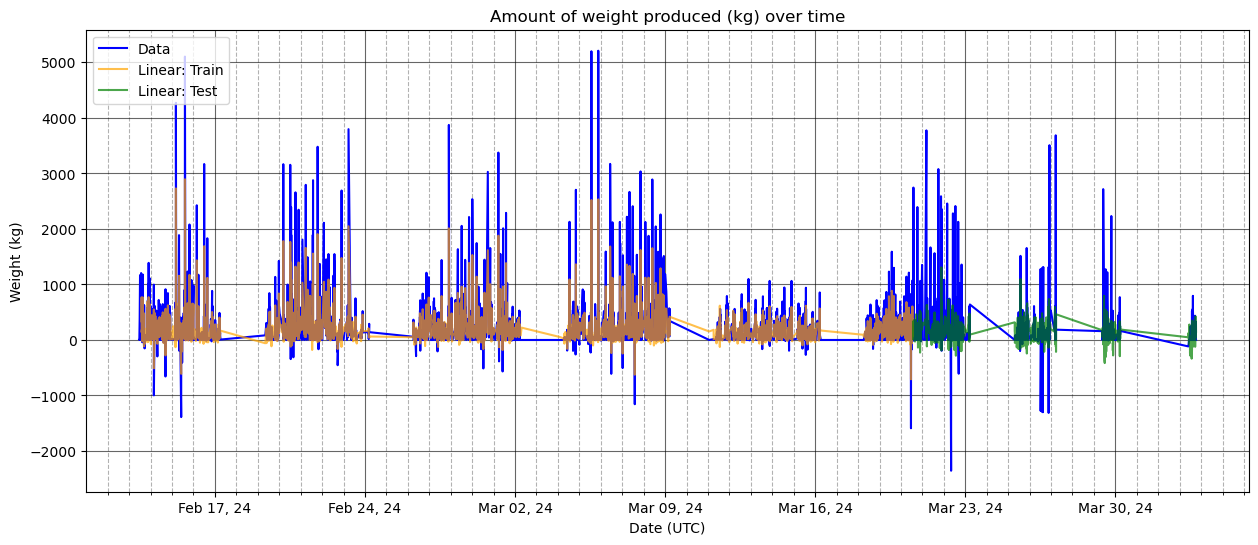

In [38]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
test_predict_plot[(2*(look_back+look_forward-1)+len(train_preds)):(2*(look_back+look_forward-1)+len(train_preds)+len(test_preds)), :] = test_preds.reshape(-1,1)

plt.plot(final_data['at'], final_data[var_to_predict], color='blue', label='Data')
plt.plot(final_data['at'], train_predict_plot, color='orange', alpha=0.7, label='Linear: Train')
plt.plot(final_data['at'], test_predict_plot, color='green', alpha=0.7, label='Linear: Test')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=1000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Weight (kg)')
plt.title('Amount of weight produced (kg) over time')

## Tree

In [39]:
# fit decision tree model
model_tree = DecisionTreeRegressor(max_depth=10)
model_tree.fit(trainX_ts_2d, trainY_ts_2d)

# evaluate model with RMSE
train_preds = scalerY.inverse_transform( model_tree.predict(trainX_ts_2d).reshape(-1,1) )
print('Training Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(trainY_ts_2d), train_preds ) ) )

test_preds = scalerY.inverse_transform( model_tree.predict(testX_ts_2d).reshape(-1,1) )
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(testY_ts_2d) , test_preds ) ) )

Training Error: 262.2091440958856
Testing Error: 437.25016761604354


In [40]:
model_tree_coefs = pd.DataFrame(
    model_tree.feature_importances_,
    index=col_names,
    columns=['coef']
)
model_tree_coefs.sort_values(by=['coef'], key=abs, ascending=False).head(20)

,coef
group_4G140400 at lag 2,0.134765
sku_762385 at lag 55,0.128416
weight_kg at lag 33,0.126154
papp at lag 15,0.063023
sku_1635500 at lag 50,0.058311
cumul_daily_energy at lag 7,0.057358
sku_1526704 at lag 40,0.048471
sku_1569349 at lag 26,0.047382
Poste de travail_40204 at lag 2,0.047293
units at lag 53,0.042026


Text(0.5, 1.0, 'Amount of weight produced (kg) over time')

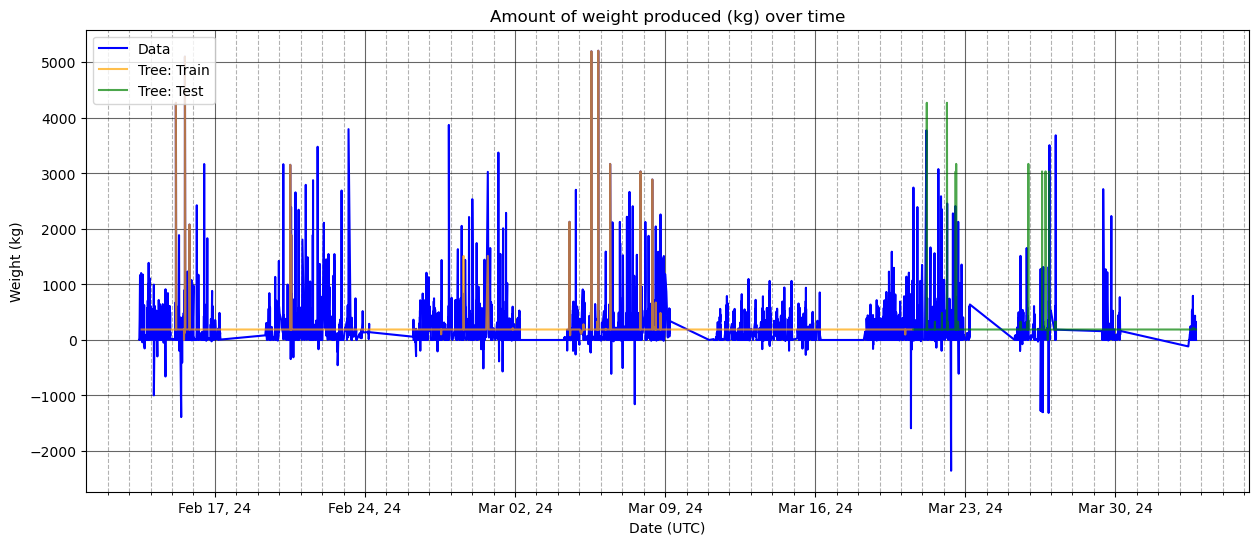

In [41]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
test_predict_plot[(2*(look_back+look_forward-1)+len(train_preds)):(2*(look_back+look_forward-1)+len(train_preds)+len(test_preds)), :] = test_preds.reshape(-1,1)

plt.plot(final_data['at'], final_data[var_to_predict], color='blue', label='Data')
plt.plot(final_data['at'], train_predict_plot, color='orange', alpha=0.7, label='Tree: Train')
plt.plot(final_data['at'], test_predict_plot, color='green', alpha=0.7, label='Tree: Test')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=1000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Weight (kg)')
plt.title('Amount of weight produced (kg) over time')

## Recurrent Neural Net

In [42]:
# define model (50-layer LSTM)
def create_lstm():
    model = Sequential()
    model.add(LSTM(50))
    model.add(Dense(30))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

In [43]:
# define model, criterion, and optimizer
model_rnn = create_lstm()
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# train model
model_hist = model_rnn.fit(
    trainX_ts, trainY_ts, epochs=30
)

Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0502 
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0056
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9157
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9195
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7829
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8709
Epoch 7/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8321
Epoch 8/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8834
Epoch 9/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8740
Epoch 10/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7812
Epoch 11/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7835
Epoch 12/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6205
Epoch 13/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6549
Epoch 14/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6339
Epoch 15/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [44]:
# evaluate model with RMSE
train_preds = scalerY.inverse_transform(model_rnn.predict(trainX_ts))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(trainY_ts), train_preds ) ) )

test_preds = scalerY.inverse_transform(model_rnn.predict(testX_ts))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scalerY.inverse_transform(testY_ts) , test_preds ) ) )

207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Training Error: 110.16543969442782
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing Error: 370.9688811007736


Text(0.5, 1.0, 'Amount of weight produced (kg) over time')

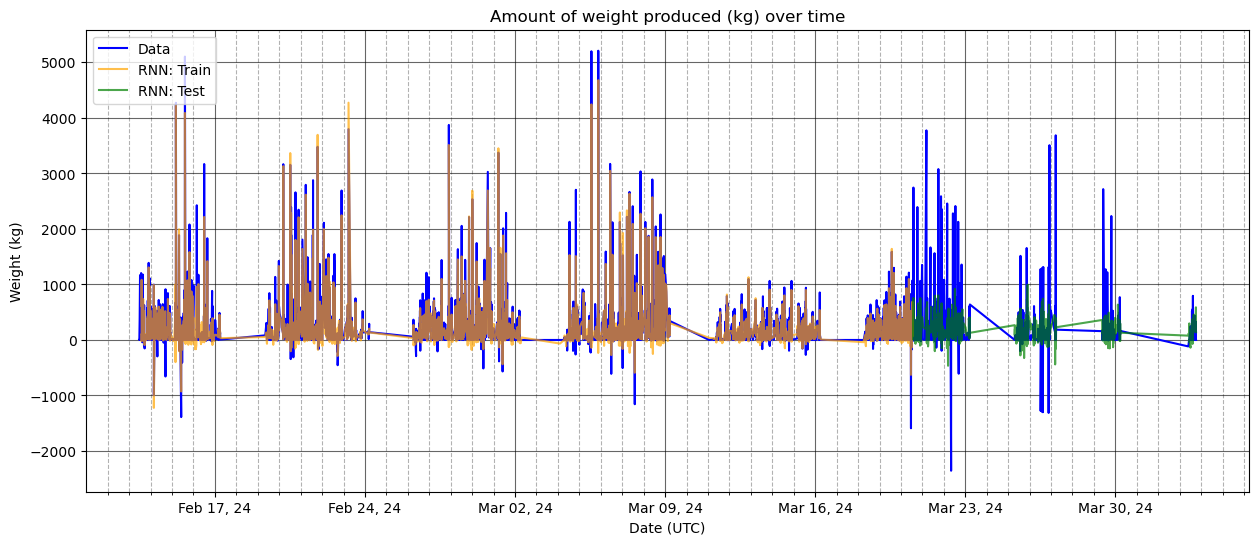

In [45]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.full(final_data[[var_to_predict]].shape, np.nan)
test_predict_plot[(2*(look_back+look_forward-1)+len(train_preds)):(2*(look_back+look_forward-1)+len(train_preds)+len(test_preds)), :] = test_preds.reshape(-1,1)

plt.plot(final_data['at'], final_data[var_to_predict], color='blue', label='Data')
plt.plot(final_data['at'], train_predict_plot, color='orange', alpha=0.7, label='RNN: Train')
plt.plot(final_data['at'], test_predict_plot, color='green', alpha=0.7, label='RNN: Test')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %y'))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=1000))

plt.grid(axis='both', which='major', color='black', alpha=0.6)
plt.grid(axis='x', which='minor', color='gray', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Weight (kg)')
plt.title('Amount of weight produced (kg) over time')